In [1]:
import pandas as pd, numpy as np, glob
import QTLfunctions as QTLfun
from matplotlib import pyplot as plt
%matplotlib inline

def makedf(paths,sep='_',fn = 1):
    df = []
    for d in paths:
        
        temp = pd.read_csv(d,index_col=0)
        temp['Chrom'] = int(d.split(sep)[fn])
        temp['Oldix'] = temp.index
        df.append(temp)
        
    return pd.concat(df).reset_index(drop=True)

## Load in chromosome map
chrommap = pd.read_csv('/home/croth/Downloads/B3502/DATA/chrommap.csv.gz')
chrommap['Seqid'] = chrommap.Contig
chrommap.drop('Contig',axis=1,inplace=True)

## Load in centormere locs
centlocs = pd.read_csv('/home/croth/Downloads/B3502/DATA/FungiDB-48_CneoformansJEC21_centromeres.csv',
                      index_col=0)

## Merge dataframes
chrommap['Chromosome'] = chrommap.index+1
chrommap = chrommap.merge(centlocs)
chrommap.head()

,Length,Cumlen,Midpts,Seqid,Chromosome,Left,Right
0,2300533,0,1150266.5,AE017341.1,1,942544,993056
1,1632307,2300533,3116686.5,AE017342.1,2,860449,900038
2,2105742,3932840,4985711.0,AE017343.1,3,806551,906800
3,1783081,6038582,6930122.5,AE017344.1,4,222000,273992
4,1507550,7821663,8575438.0,AE017345.1,5,784047,849321


In [2]:
stock_variants = pd.read_csv('/home/croth/Downloads/B3502/DATA/B3502_stocks_variants.csv',
                            index_col=0)
stock_variants.head()

,Chromosome,Pos,Aaf,Type,Nallele,Issnp,CF830,JEC20,JEC21,B3502_A1,...,Allele_1,Allele_2,Allele_3,Seqid,Qual,Depth,Vcfix,Minlen,Maxlen,Callrate
221,1,39160,0.1,del,1,0,0.0,1.0,0.0,0.0,...,AGACCCCCCCCCCCCATGT,NaN,NaN,AE017341.1,1166.50,744,221,19,19,0.9
306,1,55108,1.0,snp,2,1,NaN,NaN,1.0,1.0,...,CGTTGTTTTTT,GGTTTTTTTTT,NaN,AE017341.1,12002.60,871,306,11,11,0.8
543,1,86068,0.1,del,1,0,0.0,1.0,0.0,0.0,...,CAAAAAAAAAACGCAC,NaN,NaN,AE017341.1,3010.59,609,543,16,16,1.0
2000,1,259947,0.1,del,1,0,0.0,1.0,0.0,0.0,...,TCCCCCAT,NaN,NaN,AE017341.1,6598.33,948,2000,8,8,1.0
2261,1,323935,0.1,del,1,0,0.0,1.0,0.0,0.0,...,CAAAAAAAAAAAAAACAAGTGC,NaN,NaN,AE017341.1,2613.82,1217,2261,22,22,1.0


In [3]:
infopaths = sorted(glob.glob('../GENOTYPE/INFO/*.csv.gz'))
print(len(infopaths))

info = makedf(infopaths)
info.shape

14


(390435, 12)

In [4]:
genopaths = sorted(glob.glob('../GENOTYPE/GT/*genotype*.csv.gz'))
print(len(genopaths))

geno = makedf(genopaths)
geno.shape

14


(390435, 64)

In [5]:
samples = sorted(geno.columns.tolist()[:-2])
len(samples)

62

In [6]:
samples[-5:]

['CF830', 'JEC21', 'Stock1', 'Stock3', 'Stock4']

In [7]:
info['AF'] = (geno[samples] !=0).mean(axis=1)

In [8]:
info[(info.AF>0) & (info.AF<1)].shape[0]

8557

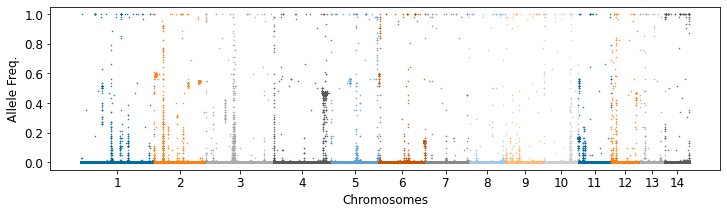

In [9]:
QTLfun.manhattan(info.sort_values('Chrom'),
                 pval='AF',ylabel='Allele Freq.');

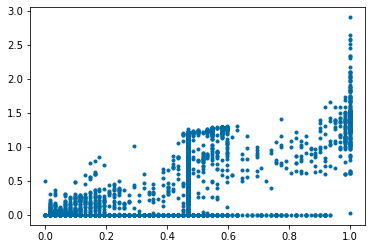

In [10]:
plt.plot(info.AF,np.log10((info.Qual/info.Depth)+1),'.');

In [11]:
depthpaths = sorted(glob.glob('../GENOTYPE/DP/*depths.csv.gz'))
len(depthpaths)

depth = makedf(depthpaths)

In [12]:
info['Mdepth'] = depth[samples].min(axis=1)
info['Meandepth'] = depth[samples].mean(axis=1)
info['Ndepth'] = np.mean(depth[samples]>=10,axis=1)

In [13]:
alleledepth = sorted(glob.glob('../GENOTYPE/AF/*ratios.csv.gz'))
len(alleledepth)

ratio = makedf(alleledepth)

In [14]:
info['Ratio'] = ratio[samples].min(axis=1)
info['Nratio'] = np.mean(ratio[samples]>.8,axis=1)

In [15]:
pheno = pd.read_csv('../PHENOTYPE/202011_WGS_B3502Progeny_phenotypes.csv.gz')
pheno.tail()

,Cross_Progeny,Phenotype on MS (N-no filamentation; Y-filamentation; L-giant cells; T-transgressive filamentation),Phenotype,Strain
52,1. B3502A1_x_CF830_Random12,N,0.0,B09
53,1. B3502A1_x_CF830_Random14,N,0.0,B10
54,1. B3502A1_x_CF830_Random20,T,2.0,B11
55,2. B3502B1_x_CF830_Random01,N,0.0,B12
56,2. B3502B1_x_CF830_Random12,Y,1.0,B20


In [16]:
info[(info.Pos==153548) & (info.Chrom==3)]

,Seqid,Pos,Qual,Callrate,Nallele,Alleles,Maxlen,Minlen,Depth,Type,Chrom,Oldix,AF,Mdepth,Meandepth,Ndepth,Ratio,Nratio
73829,AE017343.1,153548,6018.84,1.0,1,T.G,1,1,1828,snp,3,3755,0.16129,5.0,29.419355,0.967742,0.727273,0.983871


In [17]:
geno.loc[73829][['Stock1','Stock3','Stock4','JEC21','CF830']]

Stock1    0.0
Stock3    1.0
Stock4    0.0
JEC21     0.0
CF830     0.0
Name: 73829, dtype: float64

In [18]:
geno.loc[73829][samples].sum()

10.0

In [19]:
info[(info.Pos==1894056)]

,Seqid,Pos,Qual,Callrate,Nallele,Alleles,Maxlen,Minlen,Depth,Type,Chrom,Oldix,AF,Mdepth,Meandepth,Ndepth,Ratio,Nratio
110255,AE017343.1,1894056,109522.0,1.0,1,G.A,1,1,5933,snp,3,40181,0.596774,59.0,95.516129,1.0,0.983333,1.0


In [20]:
geno.loc[110255][['Stock1','Stock3','Stock4','CF830','JEC21']]

Stock1    1.0
Stock3    1.0
Stock4    1.0
CF830     0.0
JEC21     0.0
Name: 110255, dtype: float64

In [21]:
## Bring in phenotype data from Dr. Sheng Sun
phenopath = '../PHENOTYPE/202011_WGS_B3502Progeny_for_QTL.xlsx'
pheno = pd.read_excel(phenopath)
pheno['Strain'] = [''.join(a.split('_'))[:3] 
                   for a in pheno[pheno.columns[0]]]
pheno['Parent1'] = [ a.split('x')[0].split('B3502')[-1][:-1] 
                    for a in pheno['Cross_Progeny']]
pheno.index = pheno.Strain

pheno['RIC8'] = -1
pheno['RIC8'] = geno.loc[382952,pheno.index]
pheno['RHO'] = -1
pheno['RHO'] = geno.loc[110255,pheno.index]
#pheno.tail()

In [22]:
pheno[(pheno.Parent1=='B1') & 
      (pheno.RIC8==1) & (pheno.RHO==0)]

,gDNA sample for WGS,Cross_Progeny,Basidium,Phenotype on MS (N-no filamentation; Y-filamentation; L-giant cells; T-transgressive filamentation),Notes,Strain,Parent1,RIC8,RHO
Strain,,,,,,,,,
A17,A_17,2. B3502B1_x_CF830_BasidiumSpecific_03,1.0,L,NaN,A17,B1,1.0,0.0
A22,A_22,2. B3502B1_x_CF830_BasidiumSpecific_17,3.0,L,NaN,A22,B1,1.0,0.0
A26,A_26,2. B3502B1_x_CF830_BasidiumSpecific_23,4.0,L,NaN,A26,B1,1.0,0.0


In [23]:
b1segs = pheno[(pheno.Parent1=='B1') & 
               (pheno.RIC8==1) 
              ].Strain.tolist()

In [24]:
kix = geno[(geno[b1segs+['Stock1','Stock4','JEC21','CF830']].T.sum()==0) & 
     (geno['Stock3']==1) 
    ].dropna().index.values

In [56]:
genodf = pd.concat([info,geno],axis=1)

In [67]:
genodf[(genodf.Pos==1437085)][['Stock1','Stock4','Stock3']+b1segs]

,Stock1,Stock4,Stock3,A15,A16,A17,A18,A19,A20,A21,A22,A23,A24,A25,A26,A27,A28,B12,B20
213499,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [25]:
represors = info.loc[kix].sort_values('Chrom')
represors

,Seqid,Pos,Qual,Callrate,Nallele,Alleles,Maxlen,Minlen,Depth,Type,Chrom,Oldix,AF,Mdepth,Meandepth,Ndepth,Ratio,Nratio
33872,AE017341.1,2149478,4.714660e+01,1.0,1,AATTT.CATTC,5,5,6347,complex,1,33872,0.016129,43.0,100.500000,1.0,0.478992,0.564516
46098,AE017342.1,429078,6.555520e-02,1.0,1,GCATTT.ACGTTA,6,6,6267,complex,2,8756,0.016129,51.0,99.435484,1.0,0.503106,0.532258
53835,AE017342.1,789595,9.703190e-02,1.0,1,G.T,1,1,5985,snp,2,16493,0.016129,31.0,96.435484,1.0,0.376344,0.532258
100947,AE017343.1,1352772,1.877140e+02,1.0,1,A.G,1,1,5703,snp,3,30873,0.016129,33.0,91.774194,1.0,0.506667,0.532258
170422,AE017345.1,825063,0.000000e+00,1.0,1,C.T,1,1,5866,snp,5,17322,0.016129,51.0,94.370968,1.0,0.451613,0.000000
231502,AE017347.1,902053,4.291200e-08,1.0,1,ATTCA.GTTTG,5,5,5528,complex,7,17942,0.016129,32.0,87.516129,1.0,0.491071,0.483871
265673,AE017349.1,3253,7.347320e-01,1.0,1,T.C,1,1,6353,snp,9,60,0.016129,51.0,102.241935,1.0,0.430556,0.564516
265674,AE017349.1,3267,7.218630e-01,1.0,1,A.G,1,1,6576,snp,9,61,0.032258,52.0,105.709677,1.0,0.439716,0.596774
265675,AE017349.1,3276,3.449870e+01,1.0,1,CGAG.AGAAG,5,5,6268,complex,9,62,0.032258,53.0,100.032258,1.0,0.467742,0.629032
320346,AE017351.1,176756,7.539660e+02,1.0,1,T.C,1,1,4289,snp,11,4452,0.016129,28.0,69.016129,1.0,0.500000,0.548387


In [26]:
gff = QTLfun.loadgff('/home/croth/Downloads/B3502/REF/FungiDB-48_CneoformansJEC21.gff.gz')

In [27]:
gene_check = []
for i, (j,c) in enumerate(represors.iterrows()):
    k = gff[(gff.Type=='gene') & (gff.Seqid==c.Seqid) & 
        (gff.Start<=c.Pos) & (gff.End>=c.Pos)].Gene
    #print(k)
    if len(k) > 0:
        gene_check.append(k.min())
gene_check = np.unique(gene_check)
gene_check

array(['CNL04090', 'CNM00880'], dtype='<U8')

In [28]:
genech = pd.read_csv('/home/croth/Downloads/B3502/DATA/gene_changes.csv.gz')

In [29]:
genech[(genech.Gene=='CNF04940')]

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron,Chromosome,Seqid,Start,End,Strand,Description


In [30]:
genech[(genech.Gene=='CNM00880')]

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron,Chromosome,Seqid,Start,End,Strand,Description


In [31]:
gff[(gff.Gene.isin(gene_check)) & (gff.Type=='gene')]

,Seqid,Source,Type,Start,End,Score,Strand,Phase,Attribute,Parent,Gene
16408,AE017352.1,VEuPathDB,gene,113190,119528,.,-1,.,ID=CNL04090;description=phosphatidylinositol 3...,CNL04090,CNL04090
74031,AE017353.1,VEuPathDB,gene,256057,258338,.,-1,.,ID=CNM00880;description=DNA polymerase process...,CNM00880,CNM00880


In [32]:
genech[(genech.Gene.isin(gene_check))]

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron,Chromosome,Seqid,Start,End,Strand,Description


In [33]:
info.loc[(info.Pos== 388777) & (info.Chrom==14)]

,Seqid,Pos,Qual,Callrate,Nallele,Alleles,Maxlen,Minlen,Depth,Type,Chrom,Oldix,AF,Mdepth,Meandepth,Ndepth,Ratio,Nratio
382952,AE017356.1,388777,83606.9,1.0,1,TCAG.TCAT,4,4,5394,snp,14,5485,0.516129,23.0,86.354839,1.0,0.958333,1.0


In [34]:
info[(info.Chrom==14) & (info.Pos>=388700)]

,Seqid,Pos,Qual,Callrate,Nallele,Alleles,Maxlen,Minlen,Depth,Type,Chrom,Oldix,AF,Mdepth,Meandepth,Ndepth,Ratio,Nratio
382950,AE017356.1,388743,0.000000e+00,1.000000,1,T.G,1,1,5214,snp,14,5483,0.000000,24.0,83.919355,1.000000,0.918367,1.000000
382951,AE017356.1,388774,0.000000e+00,1.000000,1,T.C,1,1,5507,snp,14,5484,0.000000,25.0,88.661290,1.000000,0.884615,1.000000
382952,AE017356.1,388777,8.360690e+04,1.000000,1,TCAG.TCAT,4,4,5394,snp,14,5485,0.516129,23.0,86.354839,1.000000,0.958333,1.000000
382953,AE017356.1,388793,1.053250e-14,1.000000,1,T.G,1,1,5512,snp,14,5486,0.000000,28.0,88.806452,1.000000,0.916667,1.000000
382954,AE017356.1,388797,1.122580e-14,1.000000,1,A.C,1,1,5536,snp,14,5487,0.000000,29.0,89.225806,1.000000,0.925000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390430,AE017356.1,762590,3.418540e-13,1.000000,2,A.C.T,1,1,1802,snp,14,12963,0.000000,8.0,29.048387,0.983871,0.857143,1.000000
390431,AE017356.1,762598,0.000000e+00,1.000000,1,G.T,1,1,1598,snp,14,12964,0.000000,8.0,25.758065,0.951613,0.888889,1.000000
390432,AE017356.1,762601,2.844770e-13,1.000000,1,A.C,1,1,1558,snp,14,12965,0.000000,8.0,25.064516,0.935484,0.880000,1.000000
390433,AE017356.1,762603,1.292200e-13,1.000000,1,A.C,1,1,1513,snp,14,12966,0.000000,8.0,24.306452,0.935484,0.880000,1.000000


In [35]:
b1segs = pheno[(pheno.Parent1=='B1')].Strain.tolist()

In [36]:
b1segs

['A15',
 'A16',
 'A17',
 'A18',
 'A19',
 'A20',
 'A21',
 'A22',
 'A23',
 'A24',
 'A25',
 'A26',
 'A27',
 'A28',
 'B12',
 'B20']

In [37]:
pheno[(pheno.Parent1=='B1')]

,gDNA sample for WGS,Cross_Progeny,Basidium,Phenotype on MS (N-no filamentation; Y-filamentation; L-giant cells; T-transgressive filamentation),Notes,Strain,Parent1,RIC8,RHO
Strain,,,,,,,,,
A15,A_15,2. B3502B1_x_CF830_BasidiumSpecific_01,1.0,Y,NaN,A15,B1,1.0,1.0
A16,A_16,2. B3502B1_x_CF830_BasidiumSpecific_02,1.0,N,NaN,A16,B1,0.0,1.0
A17,A_17,2. B3502B1_x_CF830_BasidiumSpecific_03,1.0,L,NaN,A17,B1,1.0,0.0
A18,A_18,2. B3502B1_x_CF830_BasidiumSpecific_07,1.0,N,NaN,A18,B1,0.0,0.0
A19,A_19,2. B3502B1_x_CF830_BasidiumSpecific_09,2.0,N,NaN,A19,B1,0.0,1.0
A20,A_20,2. B3502B1_x_CF830_BasidiumSpecific_11,2.0,Y,NaN,A20,B1,1.0,1.0
A21,A_21,2. B3502B1_x_CF830_BasidiumSpecific_15,3.0,N,NaN,A21,B1,0.0,1.0
A22,A_22,2. B3502B1_x_CF830_BasidiumSpecific_17,3.0,L,NaN,A22,B1,1.0,0.0
A23,A_23,2. B3502B1_x_CF830_BasidiumSpecific_20,3.0,N,NaN,A23,B1,0.0,0.0


In [38]:
geno[(geno.Stock3>=1) & 
     (geno[['Stock1','Stock4']].T.sum()==0) & 
     (info.Chrom==6)].dropna()[['Stock1','Stock4','Stock3']]

,Stock1,Stock4,Stock3
213499,0.0,0.0,1.0
213507,0.0,0.0,1.0
213509,0.0,0.0,1.0
213519,0.0,0.0,1.0
213532,0.0,0.0,1.0
213534,0.0,0.0,1.0
213535,0.0,0.0,1.0


In [39]:
geno[(geno.Stock3>=1) & 
     (geno[['Stock1','Stock4']].T.sum()==0) & 
     (info.Chrom==6)].dropna()[['Stock1','Stock4','Stock3']]

,Stock1,Stock4,Stock3
213499,0.0,0.0,1.0
213507,0.0,0.0,1.0
213509,0.0,0.0,1.0
213519,0.0,0.0,1.0
213532,0.0,0.0,1.0
213534,0.0,0.0,1.0
213535,0.0,0.0,1.0


In [40]:
geno[(geno.Stock3>=1) & 
     (geno[['Stock1','Stock4']].T.sum()==0) & 
     (info.Chrom==1)].dropna()[['Stock1','Stock4','Stock3']]

,Stock1,Stock4,Stock3
7555,0.0,0.0,1.0
24230,0.0,0.0,1.0
33872,0.0,0.0,1.0


In [41]:
geno[(geno.Stock3>=1) & 
     (geno[['Stock1','Stock4']].T.sum()==0) & 
     (info.Chrom==3)].dropna()[['Stock1','Stock4','Stock3']]

,Stock1,Stock4,Stock3
73829,0.0,0.0,1.0
87511,0.0,0.0,1.0
92212,0.0,0.0,1.0
100947,0.0,0.0,1.0


In [42]:
geno[(geno.Stock3>=1) & 
     (geno[['Stock1','Stock4']].T.sum()==0) & 
     (info.Chrom==10)].dropna()[['Stock1','Stock4','Stock3']]

,Stock1,Stock4,Stock3
294018,0.0,0.0,1.0
294023,0.0,0.0,1.0
298391,0.0,0.0,1.0
315680,0.0,0.0,1.0
315851,0.0,0.0,1.0


In [43]:
info[(info.Pos==1430787)]

,Seqid,Pos,Qual,Callrate,Nallele,Alleles,Maxlen,Minlen,Depth,Type,Chrom,Oldix,AF,Mdepth,Meandepth,Ndepth,Ratio,Nratio
24230,AE017341.1,1430787,12398.3,1.0,1,G.T,1,1,4427,snp,1,24230,0.129032,20.0,71.290323,1.0,0.95,1.0


In [44]:
geno.loc[30:30][samples][['Stock1','Stock3','Stock4','JEC21','CF830']]

,Stock1,Stock3,Stock4,JEC21,CF830
30,0.0,0.0,0.0,0.0,0.0


In [45]:
geno.loc[30][samples].sum()

0.0

In [46]:
ratio.loc[30:30]['Stock3']

30    0.930464
Name: Stock3, dtype: float64

In [47]:
info[(info.Chrom==14) & (info.Pos>=386823) & 
     (info.Pos<=389688) & 
     (info.AF>0) & (info.AF<1) ]

,Seqid,Pos,Qual,Callrate,Nallele,Alleles,Maxlen,Minlen,Depth,Type,Chrom,Oldix,AF,Mdepth,Meandepth,Ndepth,Ratio,Nratio
382952,AE017356.1,388777,83606.9,1.0,1,TCAG.TCAT,4,4,5394,snp,14,5485,0.516129,23.0,86.354839,1.0,0.958333,1.0


In [48]:
stock_variants[(stock_variants.Pos>=386823) & 
               (stock_variants.Pos<=389688) &
               (stock_variants.Chromosome==14)]

,Chromosome,Pos,Aaf,Type,Nallele,Issnp,CF830,JEC20,JEC21,B3502_A1,...,Allele_1,Allele_2,Allele_3,Seqid,Qual,Depth,Vcfix,Minlen,Maxlen,Callrate
120302,14,388777,0.4,snp,1,1,0.0,0.0,0.0,1.0,...,TCAT,NaN,NaN,AE017356.1,5387.31,893,1766,4,4,1.0


In [49]:
chg = geno[(info.Chrom==14)]
chd = depth[(info.Chrom==14)]
chi = info[(info.Chrom==14)]
cha = ratio[(ratio.Chrom==14)]

In [50]:
cents = centlocs[(centlocs.Chromosome==14)][['Left','Right']].values[0]

In [51]:
info

,Seqid,Pos,Qual,Callrate,Nallele,Alleles,Maxlen,Minlen,Depth,Type,Chrom,Oldix,AF,Mdepth,Meandepth,Ndepth,Ratio,Nratio
0,AE017341.1,28,9.652930e-13,1.000000,1,A.C,1,1,4497,snp,1,0,0.0,28.0,72.370968,1.000000,0.909091,1.000000
1,AE017341.1,72,4.267170e-14,1.000000,1,T.C,1,1,6414,snp,1,1,0.0,48.0,103.145161,1.000000,0.920635,1.000000
2,AE017341.1,586,0.000000e+00,1.000000,1,A.C,1,1,6674,snp,1,2,0.0,51.0,107.370968,1.000000,0.935065,1.000000
3,AE017341.1,924,1.799120e-14,1.000000,1,T.A,1,1,7064,snp,1,3,0.0,44.0,113.887097,1.000000,0.911111,1.000000
4,AE017341.1,939,0.000000e+00,1.000000,1,A.C,1,1,7104,snp,1,4,0.0,38.0,114.483871,1.000000,0.925926,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390430,AE017356.1,762590,3.418540e-13,1.000000,2,A.C.T,1,1,1802,snp,14,12963,0.0,8.0,29.048387,0.983871,0.857143,1.000000
390431,AE017356.1,762598,0.000000e+00,1.000000,1,G.T,1,1,1598,snp,14,12964,0.0,8.0,25.758065,0.951613,0.888889,1.000000
390432,AE017356.1,762601,2.844770e-13,1.000000,1,A.C,1,1,1558,snp,14,12965,0.0,8.0,25.064516,0.935484,0.880000,1.000000
390433,AE017356.1,762603,1.292200e-13,1.000000,1,A.C,1,1,1513,snp,14,12966,0.0,8.0,24.306452,0.935484,0.880000,1.000000


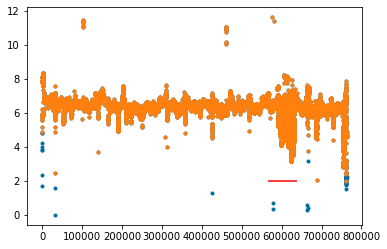

In [52]:
plt.plot(chi.Pos,np.log2(chi.Meandepth),'.');
plt.hlines(2,*cents,color='r');
plt.plot(chi[(chi.Callrate==1)].Pos,np.log2(chi[(chi.Callrate==1)].Meandepth),'.')

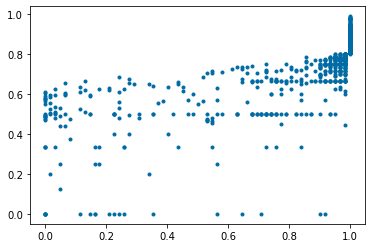

In [53]:
plt.plot(chi.Nratio,chi.Ratio,'.');

In [54]:
atleast = 3
umaf = (len(samples)-atleast)/len(samples)
lmaf = atleast/len(samples)

filt = info[(info.AF>lmaf) & 
     (info.AF<umaf) & 
    (info.)
     #(info.Ndepth>0.8) & 
     #(info.Nratio>0.8) & 
     (info.Callrate==1)].copy()
filt['Chromosome'] = filt.Chrom
filt.shape

SyntaxError: invalid syntax (<ipython-input-54-c26196586afc>, line 7)

In [ ]:
loci = geno.loc[filt.index,samples].drop_duplicates()

In [ ]:
chrommap

In [ ]:
MAT = [1529240,1661861]

In [ ]:
fig,ax = plt.subplots(7,2,figsize=(20,15),sharex=True,sharey=True)

for i,(j,c) in enumerate(chrommap.iterrows()):
    
    plt.sca(ax.ravel()[i])
    plt.hlines(0.5,0,c.Length,color='k',linestyle='--')
    
    plt.hlines(0.5,c.Left,c.Right,color='r',linewidth=5)
    
    temp = filt[(filt.Seqid==c.Seqid)]
    
    
    plt.plot(temp.Pos,temp.AF,'ko')
    plt.title(i+1,y=.8)
    
plt.sca(ax.ravel()[3])
plt.hlines(0.5,*MAT,color='g',linewidth=5)

plt.ylim(0,1)
plt.subplots_adjust(wspace=0.1);

In [ ]:
filt[(filt.Chromosome==4)].shape

In [ ]:
geno.loc[filt[(filt.Chromosome==4)].index,
         samples
        ].drop_duplicates().shape

In [ ]:
filt[(filt.Chromosome==11)]

In [ ]:
info[(info.Chrom==11) & 
     (info.Callrate==1) & 
     (info.AF>0) & 
     (info.AF<1) & (info.Type=='snp')]

In [ ]:
info[(info.Chrom==12) & (info.Pos>773178) & (info.Pos<774000) & (info.AF>0)]

In [ ]:
ratio[(info.Chrom==12) & (info.Pos>773178) & (info.Pos<774000) & (info.AF>0)]

In [ ]:
info[(info.Chrom==11) & (info.Pos==823427)]

In [ ]:
loci = pd.concat([filt,geno.loc[filt.index,samples]],axis=1)

In [ ]:
loci.to_csv('../GENOTYPE/B3502_progeny_variants.csv.gz',index=True)

In [ ]:
stock_variants[(stock_variants.Chromosome==7) & 
               (stock_variants.Pos==890559)][
                ['CF830','B3502_A1','B3502_B1','B3502_B7']]

In [ ]:
filt[(filt.AF<.25) & (filt.Chromosome==7)]

In [ ]:
stock_variants.shape

In [ ]:
assert 1 == 0
mydpi = 150
for s in samples[:5]:
    
    temp = info.copy()
    temp['Ratio'] = ratio[s]
    temp['Geno'] = geno[s]
    temp['SDepth'] = np.log2(depth[s]+1)
    temp = temp.merge(chrommap[['Seqid','Cumlen']])
    #print(temp.shape)
    #temp = temp.loc[info[(info.AF>0) & 
    #                     (info.AF<1) & 
    #                      (info.depth>8)].index,:]
   
    fig,ax = plt.subplots(2,1,figsize=(12,5),sharex=True);
    fig.set_facecolor('w')
    plt.sca(ax[0])
    
    g0 = temp[(temp.Geno==0)]
    g1 = temp[(temp.Geno!=0)]
    
    plt.plot(g0.Pos+g0.Cumlen,g0.SDepth,'.',
             color='tab:blue',ms=2,alpha=0.5)
    plt.plot(g1.Pos+g1.Cumlen,g1.SDepth,'.',
             color='tab:orange',ms=2,alpha=0.5)
    
    plt.xticks(chrommap.Midpts,
               np.arange(chrommap.shape[0])+1,
               fontsize=12)
    yp,yl = plt.yticks()
    
    plt.vlines(chrommap.Cumlen.values[1:],
               yp[1],yp[-2],color='k',
               linestyle='--',linewidth=1,
              alpha =0.52)
    
    sp = pheno[(pheno.Strain==s)][pheno.columns[2]].min()
    
    plt.title('Strain: %s | Phenotype: %s'%(s,sp),fontsize=12)
    plt.ylabel('-log$_2$ Read Depth',fontsize=12)
    
    for i,c in chrommap.iterrows():
        plt.hlines(0,c.Left+c.Cumlen,
                  c.Right+c.Cumlen,
               color='k')
    
    plt.sca(ax[1])
    
    plt.plot(g0.Pos+g0.Cumlen,g0.Ratio,'.',
             color='tab:blue',ms=1,alpha=0.2)
    plt.plot(g1.Pos+g1.Cumlen,g1.Ratio,'.',
             color='tab:orange',ms=1,alpha=0.2)
    
    plt.xticks(chrommap.Midpts,
               np.arange(chrommap.shape[0])+1,
               fontsize=12)
    
    plt.vlines(chrommap.Cumlen.values[1:],
               0,1,color='k',
               linestyle='--',linewidth=1,
              alpha =0.52)
    
    plt.ylabel('Allelic Ratio',fontsize=12)
    plt.xlabel('Chromosome',fontsize=12)
    
    plt.savefig('../FIGURES/DEPTHPLOTS/%s.png'%(s),
             dpi=mydpi,bbox_inches='tight')
    plt.close()